In [1]:
import pandas as pd
import numpy as np
import matplotlib as mtp
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
import tensorflow as tf

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
from glob import glob

msk_paths = glob('../input/lgg-mri-segmentation/kaggle_3m/*/*_mask*')
img_paths = [m.replace('_mask','') for m in msk_paths]

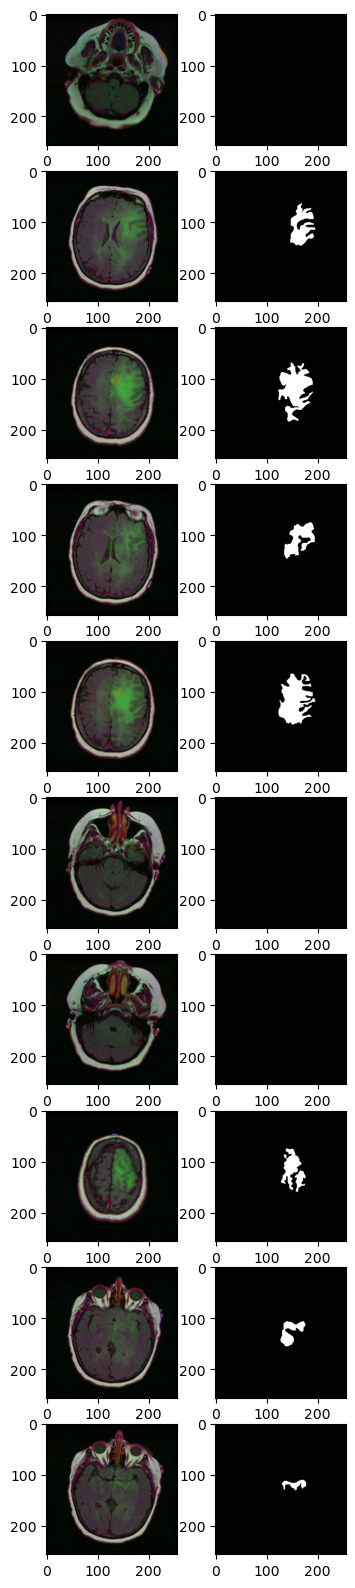

In [3]:
import cv2

rows, cols = 10, 2

fig = plt.figure(figsize = (4, 20))
for i in range(1, rows*cols, 2):
    
    fig.add_subplot(rows, cols, i)
    img = cv2.imread(img_paths[i])
    plt.imshow(img)

    fig.add_subplot(rows, cols, i+1)
    msk = cv2.imread(msk_paths[i])
    plt.imshow(msk)


In [4]:
mri_df = pd.DataFrame({'img':img_paths,
                       'msk':msk_paths})
mri_df.head()

,img,msk
0,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...
1,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...
2,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...
3,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...
4,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...


In [5]:
from sklearn.model_selection import train_test_split

mri_df_train, mri_df_test = train_test_split(mri_df, test_size = 0.1,random_state=77_47)
mri_df_train, mri_df_val = train_test_split(mri_df_train, test_size = 0.1,random_state=77_47)

mri_df_train = mri_df_train.reset_index(drop=True)
mri_df_val = mri_df_val.reset_index(drop=True)
mri_df_test = mri_df_test.reset_index(drop=True)

In [6]:
print(mri_df_train.shape,
      mri_df_val.shape,
      mri_df_test.shape)

(3182, 2) (354, 2) (393, 2)


In [7]:
from keras.preprocessing.image import ImageDataGenerator

# assuming an human precision of 1% for manual tasks, so I'll use 2% for a safaty error margin
BATCH_SIZE = 32

def transformator(df,
                  rotation_range=0.2,
                  width_shift_range=0.02,
                  height_shift_range=0.02,
                  shear_range=0.1,
                  zoom_range=0.1,
                  horizontal_flip=True,
                  IMG_SIZE_TRAIN = (128,128),
                  BATCH_SIZE = 32):

  img_datag = ImageDataGenerator(
                rotation_range=rotation_range,
                width_shift_range=width_shift_range,
                height_shift_range=height_shift_range,
                shear_range=shear_range,
                zoom_range=zoom_range,
                horizontal_flip=True,
                fill_mode='nearest')

  msk_datag = ImageDataGenerator(
                rotation_range=rotation_range,
                width_shift_range=width_shift_range,
                height_shift_range=height_shift_range,
                shear_range=shear_range,
                zoom_range=zoom_range,
                horizontal_flip=True,
                fill_mode='nearest')

  img_generated = img_datag.flow_from_dataframe(
                      df,
                      x_col = 'img',
                      class_mode = None,
                      color_mode = 'rgb',
                      target_size = IMG_SIZE_TRAIN,
                      batch_size = BATCH_SIZE,
                      save_to_dir = None,
                      save_prefix = 'image',
                      seed = 777447)

  msk_generated = msk_datag.flow_from_dataframe(
                      df,
                      x_col='msk',
                      class_mode=None,
                      color_mode='grayscale',
                      target_size=IMG_SIZE_TRAIN,
                      batch_size=BATCH_SIZE,
                      save_to_dir=None,
                      save_prefix='mask',
                      seed=777447)

  generated = zip(img_generated, msk_generated)

  for img, msk in generated:
      img = img / 255
      msk = msk / 255

      msk[msk > 0.5] = 1
      msk[msk <= 0.5] = 0

      yield (img,msk)

data_train = transformator(mri_df_train)
data_val = transformator(mri_df_val)
data_test = transformator(mri_df_test)

In [8]:
import keras.layers as ls
import keras

inp = ls.Input((128,128,3))

c1 = ls.Conv2D(32, (3, 3),padding='same')(inp)
b1 = ls.Activation('relu')(c1)
c1 = ls.Conv2D(32, (3, 3), padding='same')(b1)
b1 = ls.BatchNormalization(axis=3)(c1)
b1 = ls.Activation('relu')(b1)
p1 = ls.MaxPooling2D(pool_size=(2, 2))(b1)

c2 = ls.Conv2D(64, (3,3),padding='same')(p1)
b2 = ls.Activation('relu')(c2)
c2 = ls.Conv2D(64, (3, 3), padding='same')(b2)
b2 = ls.BatchNormalization(axis=3)(c2)
b2 = ls.Activation('relu')(b2)
p2 = ls.MaxPooling2D(pool_size=(2, 2))(b2)

c3 = ls.Conv2D(128, (3,3),padding='same')(p2)
b3 = ls.Activation('relu')(c3)
c3 = ls.Conv2D(128, (3, 3), padding='same')(b3)
b3 = ls.BatchNormalization(axis=3)(c3)
b3 = ls.Activation('relu')(b3)
p3 = ls.MaxPooling2D(pool_size=(2, 2))(b3)

c4 = ls.Conv2D(256, (3,3),padding='same')(p3)
b4 = ls.Activation('relu')(c4)
c4 = ls.Conv2D(256, (3, 3), padding='same')(b4)
b4 = ls.BatchNormalization(axis=3)(c4)
b4 = ls.Activation('relu')(b4)
p4 = ls.MaxPooling2D(pool_size=(2, 2))(b4)

c5 = ls.Conv2D(512, (3,3),padding='same')(p4)
b5 = ls.Activation('relu')(c5)
c5 = ls.Conv2D(512, (3, 3), padding='same')(b5)
b5 = ls.BatchNormalization(axis=3)(c5)
b5 = ls.Activation('relu')(b5)
p5 = ls.MaxPooling2D(pool_size=(2, 2))(b5)

u6 = ls.concatenate([ls.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(b5), c4], axis=3)
c6 = ls.Conv2D(256, (3, 3), padding='same')(u6)
b6 = ls.Activation('relu')(c6)
c6 = ls.Conv2D(256, (3, 3), padding='same')(b6)
b6 = ls.BatchNormalization(axis=3)(c6)
b6 = ls.Activation('relu')(b6)

u7 = ls.concatenate([ls.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(b6), c3], axis=3)
c7 = ls.Conv2D(128, (3, 3), padding='same')(u7)
b7 = ls.Activation('relu')(c7)
c7 = ls.Conv2D(128, (3, 3), padding='same')(b7)
b7 = ls.BatchNormalization(axis=3)(c7)
b7 = ls.Activation('relu')(b7)

u8 = ls.concatenate([ls.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(b7), c2], axis=3)
c8 = ls.Conv2D(64, (3, 3), padding='same')(u8)
b8 = ls.Activation('relu')(c8)
c8 = ls.Conv2D(64, (3, 3), padding='same')(b8)
b8 = ls.BatchNormalization(axis=3)(c8)
b8 = ls.Activation('relu')(b8)

u9 = ls.concatenate([ls.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(b8), c1], axis=3)
c9 = ls.Conv2D(32, (3, 3), padding='same')(u9)
b9 = ls.Activation('relu')(c9)
c9 = ls.Conv2D(32, (3, 3), padding='same')(b9)
b9 = ls.BatchNormalization(axis=3)(c9)
b9 = ls.Activation('relu')(b9)

c10 = ls.Conv2D(1, (1, 1), activation='sigmoid')(b9)

model = keras.Model(inputs=[inp],
                    outputs=[c10])

In [9]:
import keras.backend as K

smooth=100

def dice_coef(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)

    intersec = K.sum(y_true * y_pred)
    mod_sum = K.sum(y_true) + K.sum(y_pred)

    return (2 * intersec + smooth) / (mod_sum + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersec = K.sum(y_true * y_pred)
    comb_area = K.sum(y_true + y_pred) - intersec

    return (intersec + smooth) / (comb_area + smooth)

def iou_loss(y_true, y_pred):
  return - iou(y_true, y_pred)

In [10]:
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

model.compile(optimizer = Adam(learning_rate=0.0001),
              loss = iou_loss,
              metrics=["binary_accuracy", iou, dice_coef])


In [12]:
history = model.fit(data_train,
                    steps_per_epoch=(len(mri_df_train) / BATCH_SIZE),
                    epochs=10,
                    callbacks=[ModelCheckpoint('unet_128_mri_seg.hdf5', verbose=1, save_best_only=True)],
                    validation_data = data_val,
                    validation_steps=len(mri_df_val) / BATCH_SIZE)

Epoch 1/10
100/99 [==============================] - ETA: 0s - loss: -0.0559 - binary_accuracy: 0.9841 - iou: 0.0560 - dice_coef: 0.1047
Epoch 1: val_loss improved from inf to -0.05053, saving model to unet_128_mri_seg.hdf5
99/99 [==============================] - 33s 335ms/step - loss: -0.0559 - binary_accuracy: 0.9841 - iou: 0.0560 - dice_coef: 0.1047 - val_loss: -0.0505 - val_binary_accuracy: 0.9945 - val_iou: 0.0511 - val_dice_coef: 0.0942
Epoch 2/10
100/99 [==============================] - ETA: 0s - loss: -0.0627 - binary_accuracy: 0.9861 - iou: 0.0629 - dice_coef: 0.1167
Epoch 2: val_loss improved from -0.05053 to -0.07305, saving model to unet_128_mri_seg.hdf5
99/99 [==============================] - 34s 339ms/step - loss: -0.0627 - binary_accuracy: 0.9861 - iou: 0.0629 - dice_coef: 0.1167 - val_loss: -0.0730 - val_binary_accuracy: 0.9843 - val_iou: 0.0692 - val_dice_coef: 0.1255
Epoch 3/10
100/99 [==============================] - ETA: 0s - loss: -0.0699 - binary_accuracy: 0.9

In [13]:
results = model.evaluate(data_test, steps=len(mri_df_test) / BATCH_SIZE)

print("Test loss: ",round(results[0],3),
      "Test Binary Accuracy: ",round(results[1],3),
      "Test IOU: ",round(results[2],3),
      "Test Dice Coefficent: ",round(results[3],3))

Found 393 validated image filenames.
Found 393 validated image filenames.
12/12 [==============================] - 7s 578ms/step - loss: -0.2164 - binary_accuracy: 0.9952 - iou: 0.2158 - dice_coef: 0.3500
Test loss:  -0.216 Test Binary Accuracy:  0.995 Test IOU:  0.216 Test Dice Coefficent:  0.35


1/1 [==============================] - 0s 20ms/step


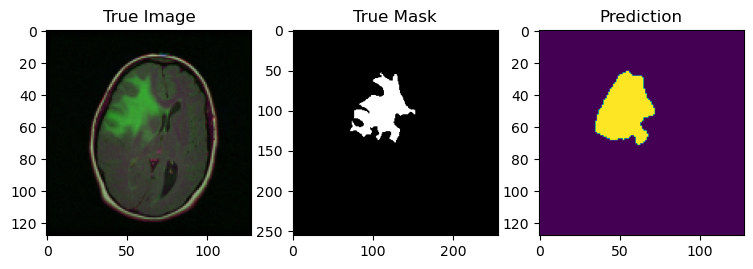

1/1 [==============================] - 0s 21ms/step


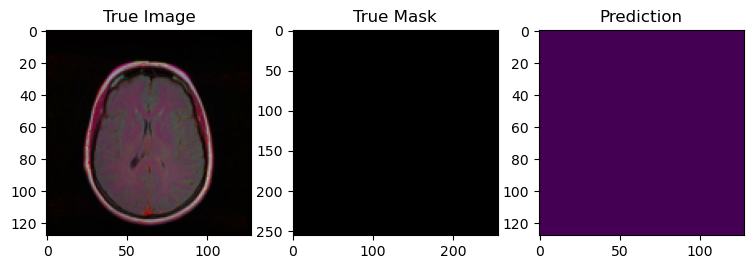

1/1 [==============================] - 0s 19ms/step


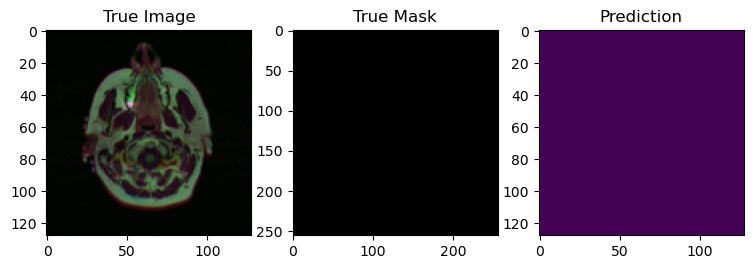

1/1 [==============================] - 0s 19ms/step


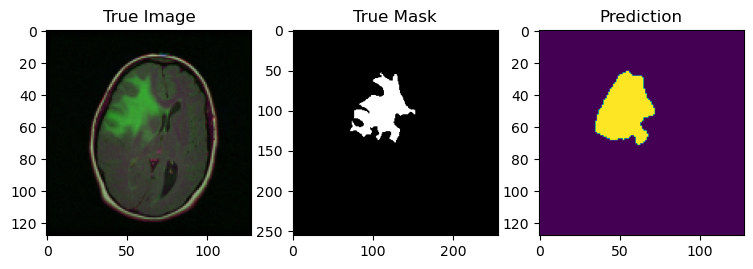

1/1 [==============================] - 0s 19ms/step


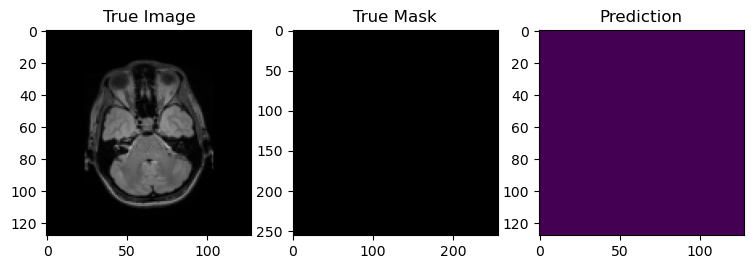

1/1 [==============================] - 0s 19ms/step


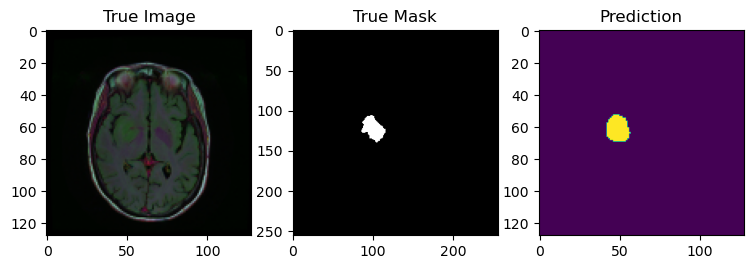

1/1 [==============================] - 0s 19ms/step


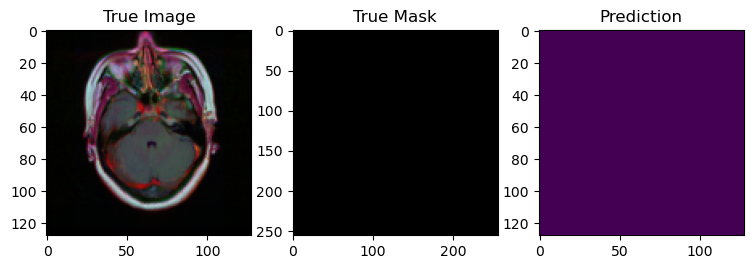

1/1 [==============================] - 0s 19ms/step


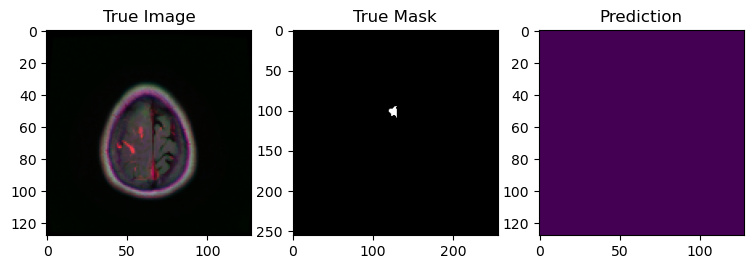

1/1 [==============================] - 0s 19ms/step


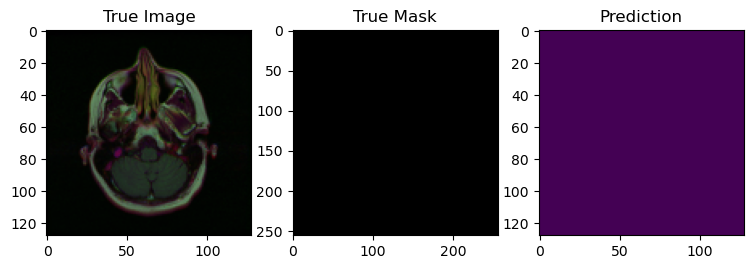

1/1 [==============================] - 0s 19ms/step


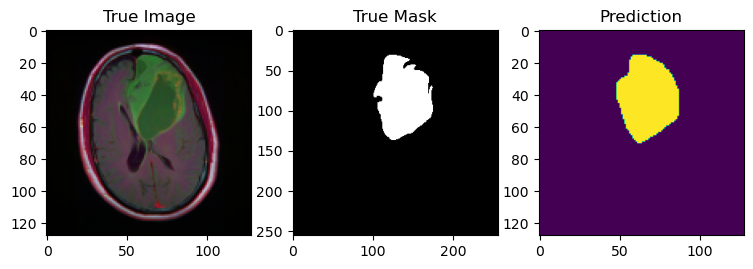

In [17]:
for i in range(10):
    index=np.random.randint(1,len(mri_df_test.index))
    img = cv2.imread(mri_df_test['img'].iloc[index])
    img = cv2.resize(img ,(128, 128))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(9,9))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('True Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.imread(mri_df_test['msk'].iloc[index])))
    plt.title('True Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.show()

1/1 [==============================] - 0s 20ms/step


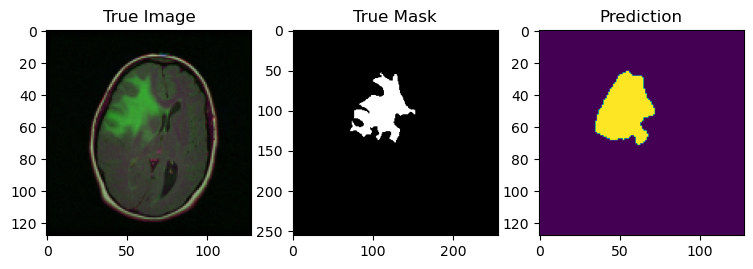

1/1 [==============================] - 0s 21ms/step


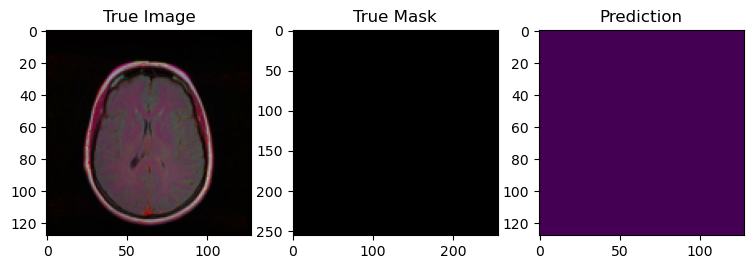

1/1 [==============================] - 0s 19ms/step


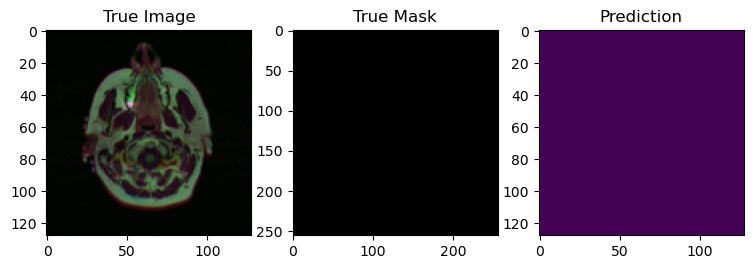

1/1 [==============================] - 0s 19ms/step


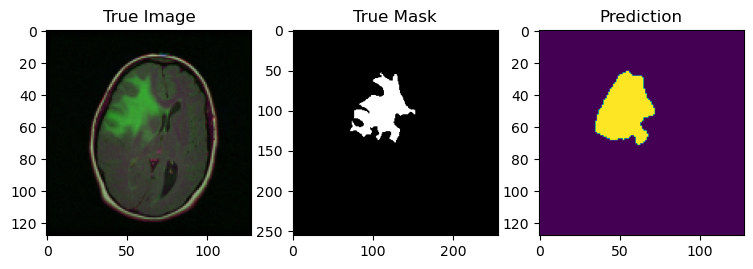

1/1 [==============================] - 0s 19ms/step


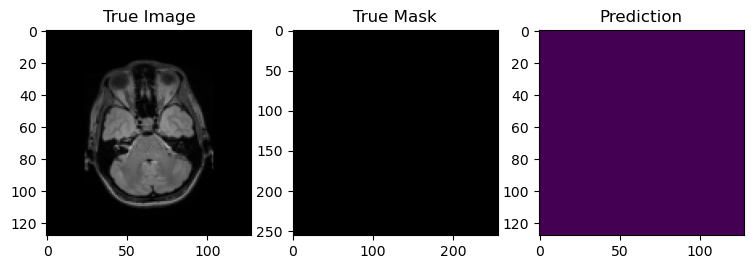

1/1 [==============================] - 0s 19ms/step


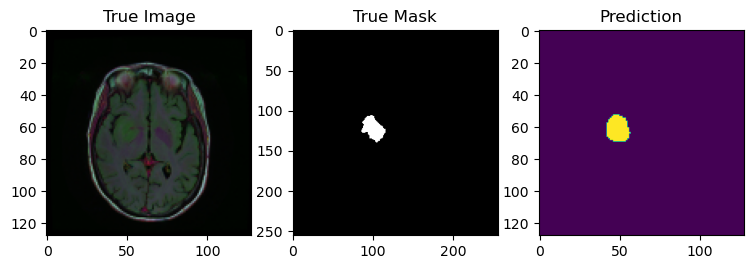

1/1 [==============================] - 0s 19ms/step


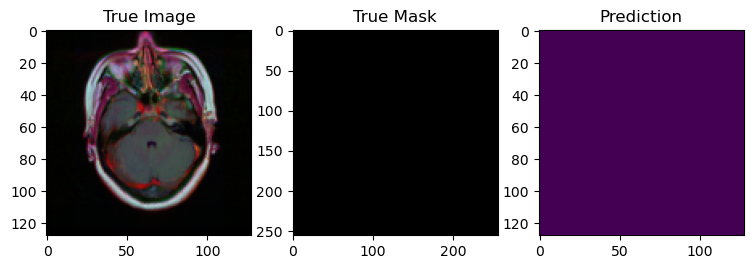

1/1 [==============================] - 0s 19ms/step


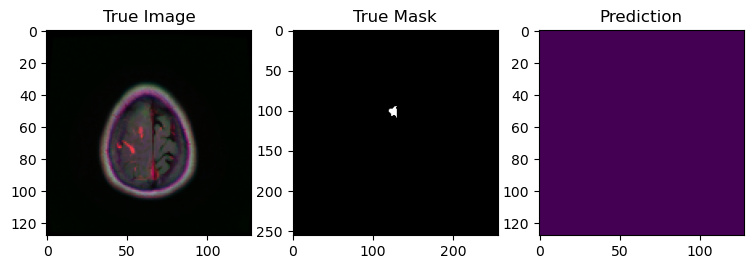

1/1 [==============================] - 0s 19ms/step


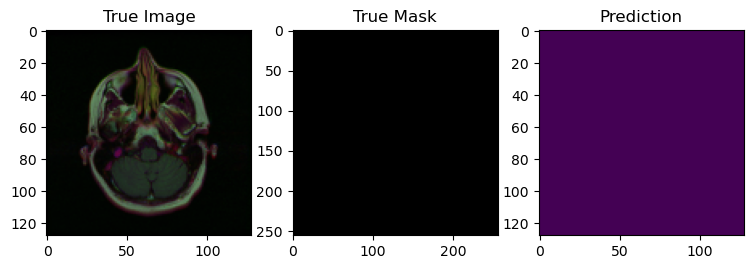

1/1 [==============================] - 0s 19ms/step


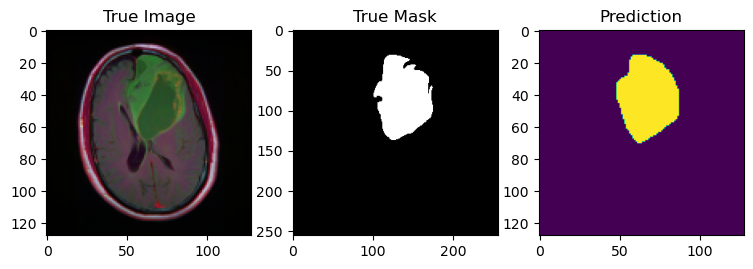

In [ ]:
for i in range(10):
    index=np.random.randint(1,len(mri_df_test.index))
    img = cv2.imread(mri_df_test['img'].iloc[index])
    img = cv2.resize(img ,(128, 128))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(9,9))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('True Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.imread(mri_df_test['msk'].iloc[index])))
    plt.title('True Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.show()

In [19]:
from IPython.display import FileLink

# Provide a download link
FileLink(r'unet_128_mri_seg.hdf5')

/kaggle/working/unet_128_mri_seg.hdf5